# MLOps - Heart Disease Prediction

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    roc_auc_score, roc_curve, confusion_matrix,
    classification_report
)
import mlflow
import mlflow.sklearn
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")


Libraries imported successfully!


## Data Acquisition & Exploratory Data Analysis (EDA)

### Step 1: Data Acquisition

In [29]:
from ucimlrepo import fetch_ucirepo 


heart_disease = fetch_ucirepo(id=45) 

X = heart_disease.data.features 
y = heart_disease.data.targets 

print("Dataset Metadata:")
print(heart_disease.metadata)
print("\n" + "="*80 + "\n")

print("Variable Information:")
print(heart_disease.variables)


Dataset Metadata:
{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi

In [30]:
# Combine features and target into a single dataframe for easier analysis
df = pd.concat([X, y], axis=1)

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())


Dataset Shape: (303, 14)

First few rows:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

    ca  thal  num  
0  0.0   6.0    0  
1  3.0   3.0    2  
2  2.0   7.0    1  
3  0.0   3.0    0  
4  0.0   3.0    0  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64

### Step 2: Data Cleaning and Preprocessing


In [31]:

print("Missing Values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])
if missing_values.sum() == 0:
    print("No missing values found!")
else:
    print(f"\nTotal missing values: {missing_values.sum()}")
    # Handle missing values if any
    df = df.fillna(df.median(numeric_only=True))


Missing Values:
ca      4
thal    2
dtype: int64

Total missing values: 6


In [32]:
# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
if duplicates > 0:
    print("Removing duplicate rows...")
    df = df.drop_duplicates()
    print(f"Dataset shape after removing duplicates: {df.shape}")


Number of duplicate rows: 0


In [33]:
# Check target variable distribution and encoding
print("Target variable unique values:", df.iloc[:, -1].unique())
print("\nTarget variable value counts:")
print(df.iloc[:, -1].value_counts())

# Handle target variable - convert to binary if needed
target_col = df.columns[-1]
if df[target_col].dtype == 'object' or df[target_col].nunique() > 2:
    # Encode target variable to binary (0: no disease, 1: disease)
    le_target = LabelEncoder()
    df[target_col] = le_target.fit_transform(df[target_col])
    # If more than 2 classes, convert to binary (0 = no disease, 1+ = disease)
    if df[target_col].nunique() > 2:
        df[target_col] = (df[target_col] > 0).astype(int)
    
print("\nTarget variable after encoding:")
print(df[target_col].value_counts())
print(f"\nClass distribution:\n{df[target_col].value_counts(normalize=True) * 100}")


Target variable unique values: [0 2 1 3 4]

Target variable value counts:
num
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64

Target variable after encoding:
num
0    164
1    139
Name: count, dtype: int64

Class distribution:
num
0    54.125413
1    45.874587
Name: proportion, dtype: float64


In [34]:
# Separate features and target again after cleaning
X_clean = df.iloc[:, :-1]
y_clean = df.iloc[:, -1]

# Check data types and handle categorical features
print("Feature data types:")
print(X_clean.dtypes)
print("\nCategorical features:")
categorical_features = X_clean.select_dtypes(include=['object']).columns.tolist()
print(categorical_features)

# Encode categorical features if any
if categorical_features:
    le_dict = {}
    for col in categorical_features:
        le = LabelEncoder()
        X_clean[col] = le.fit_transform(X_clean[col].astype(str))
        le_dict[col] = le
    print(f"\nEncoded {len(categorical_features)} categorical features")
else:
    print("\nNo categorical features found - all features are numerical")


Feature data types:
age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca          float64
thal        float64
dtype: object

Categorical features:
[]

No categorical features found - all features are numerical


In [35]:
# Check for outliers using IQR method
print("Checking for outliers in numerical features...")
outlier_info = {}
for col in X_clean.select_dtypes(include=[np.number]).columns:
    Q1 = X_clean[col].quantile(0.25)
    Q3 = X_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((X_clean[col] < lower_bound) | (X_clean[col] > upper_bound)).sum()
    if outliers > 0:
        outlier_info[col] = outliers
        print(f"{col}: {outliers} outliers ({outliers/len(X_clean)*100:.2f}%)")

if not outlier_info:
    print("No significant outliers detected using IQR method")
else:
    print(f"\nTotal features with outliers: {len(outlier_info)}")
    # Note: We'll keep outliers as they might be clinically significant for medical data


Checking for outliers in numerical features...
cp: 23 outliers (7.59%)
trestbps: 9 outliers (2.97%)
chol: 5 outliers (1.65%)
fbs: 45 outliers (14.85%)
thalach: 1 outliers (0.33%)
oldpeak: 5 outliers (1.65%)
ca: 20 outliers (6.60%)

Total features with outliers: 7


### Step 3: Exploratory Data Analysis (EDA)


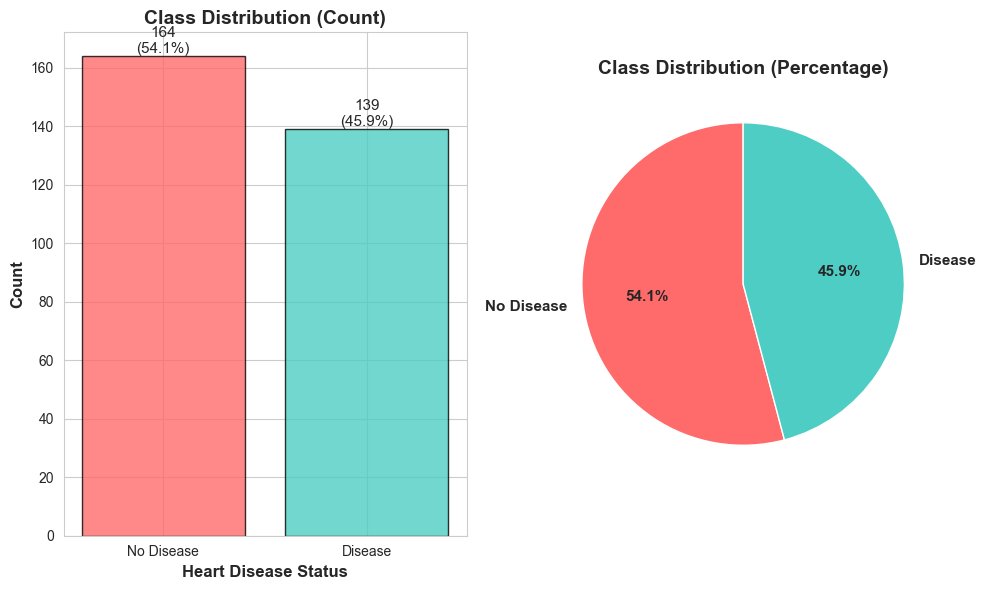


Class Balance:
No Disease (0): 164 (54.13%)
Disease (1): 139 (45.87%)
Balance Ratio: 0.848


In [36]:
# Class Balance Visualization
plt.figure(figsize=(10, 6))
class_counts = y_clean.value_counts()
colors = ['#ff6b6b', '#4ecdc4']
plt.subplot(1, 2, 1)
bars = plt.bar(class_counts.index, class_counts.values, color=colors, alpha=0.8, edgecolor='black')
plt.xlabel('Heart Disease Status', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12, fontweight='bold')
plt.title('Class Distribution (Count)', fontsize=14, fontweight='bold')
plt.xticks([0, 1], ['No Disease', 'Disease'])
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}\n({height/len(y_clean)*100:.1f}%)',
             ha='center', va='bottom', fontsize=11)

plt.subplot(1, 2, 2)
plt.pie(class_counts.values, labels=['No Disease', 'Disease'], autopct='%1.1f%%',
        colors=colors, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
plt.title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('class_balance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nClass Balance:")
print(f"No Disease (0): {class_counts[0]} ({class_counts[0]/len(y_clean)*100:.2f}%)")
print(f"Disease (1): {class_counts[1]} ({class_counts[1]/len(y_clean)*100:.2f}%)")
print(f"Balance Ratio: {min(class_counts)/max(class_counts):.3f}")


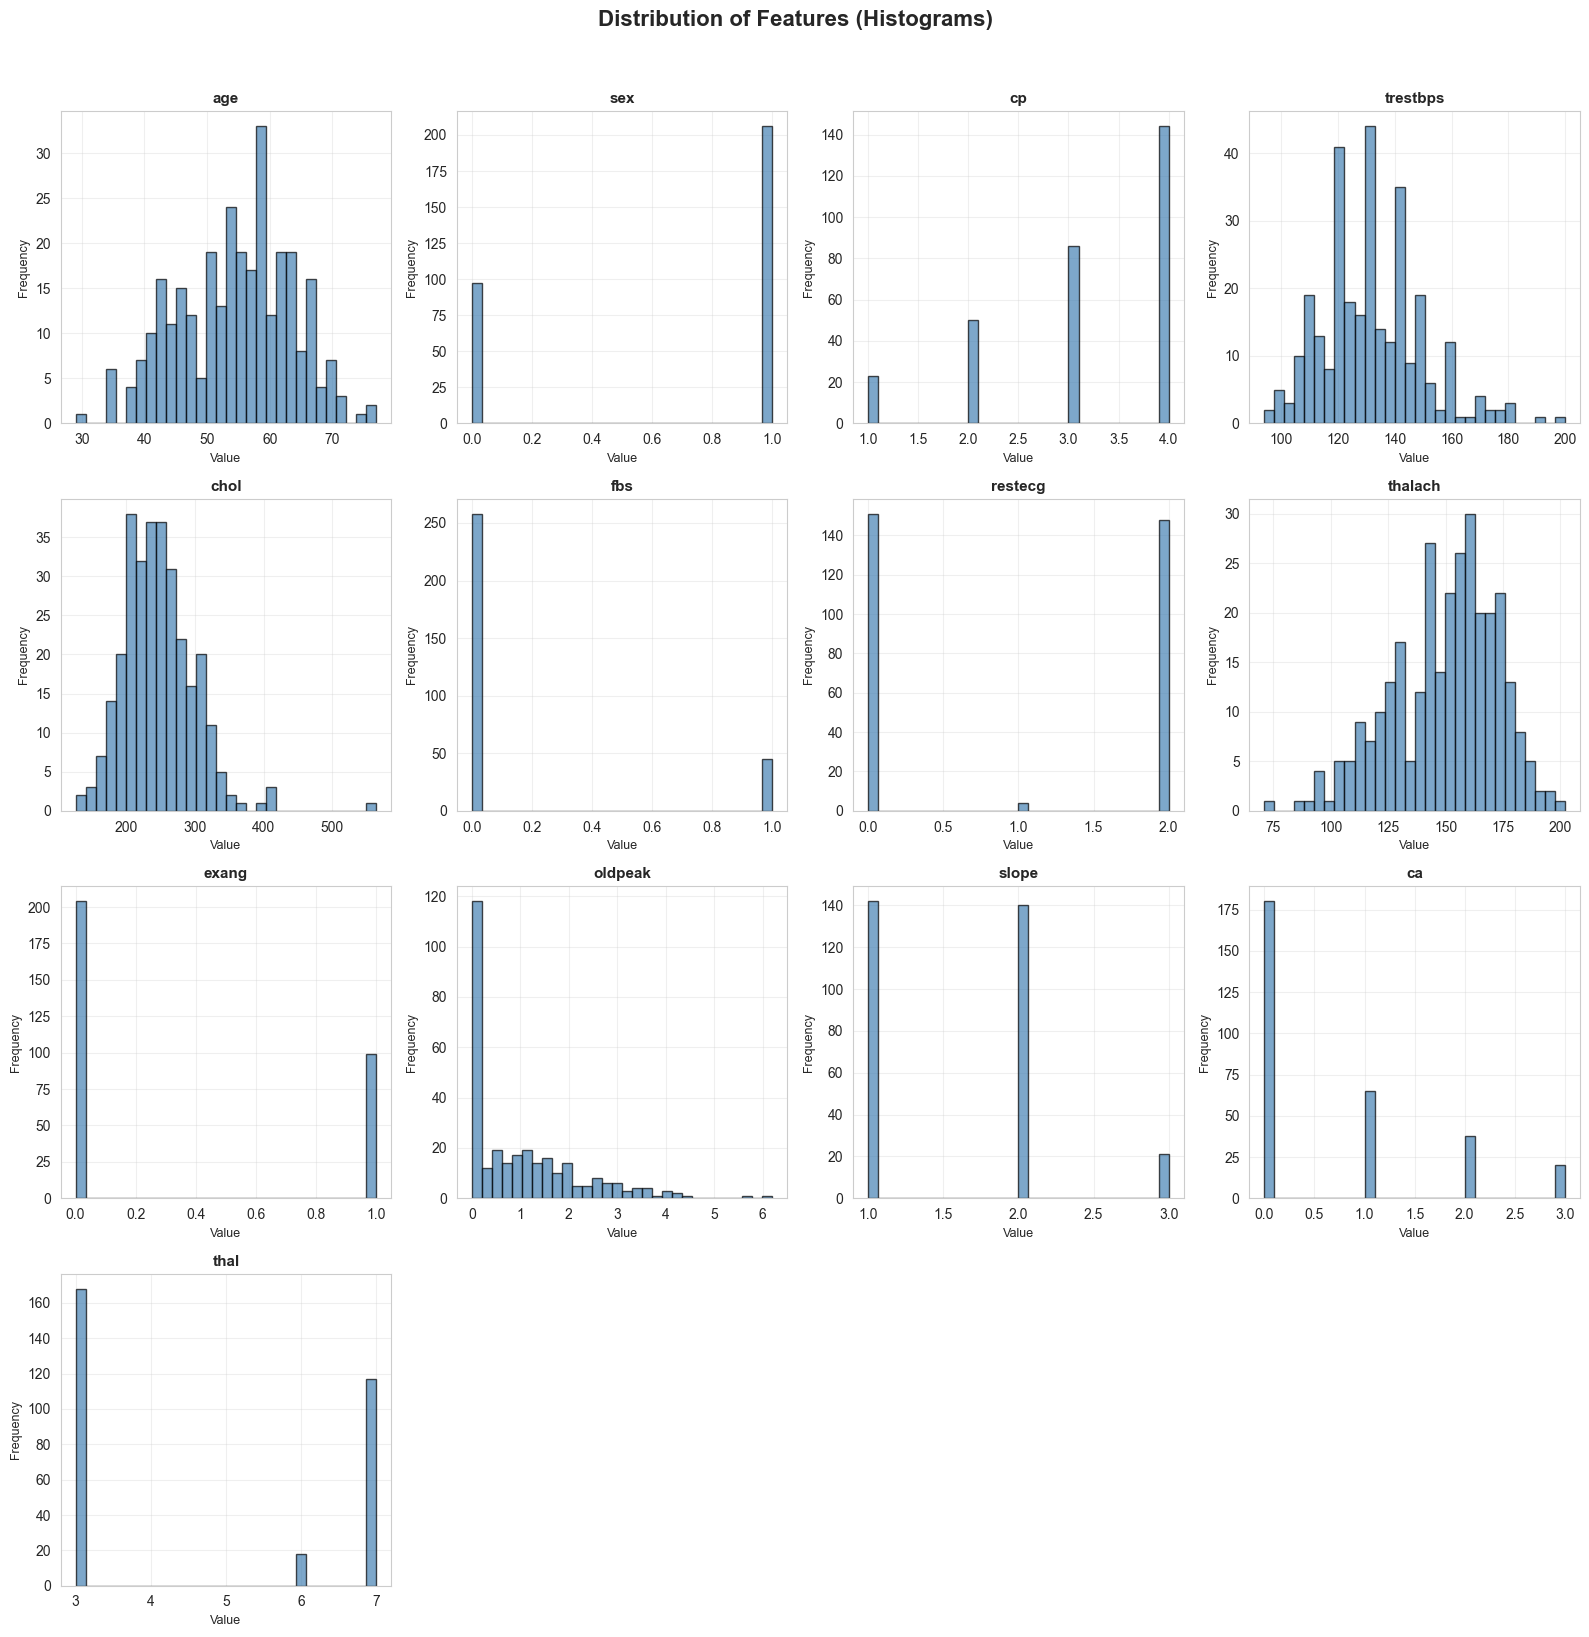

In [37]:
# Histograms for all numerical features
n_features = len(X_clean.columns)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
axes = axes.flatten()

for idx, col in enumerate(X_clean.columns):
    ax = axes[idx]
    ax.hist(X_clean[col], bins=30, color='steelblue', alpha=0.7, edgecolor='black')
    ax.set_title(f'{col}', fontsize=11, fontweight='bold')
    ax.set_xlabel('Value', fontsize=9)
    ax.set_ylabel('Frequency', fontsize=9)
    ax.grid(True, alpha=0.3)

# Hide extra subplots
for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Distribution of Features (Histograms)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('feature_histograms.png', dpi=300, bbox_inches='tight')
plt.show()


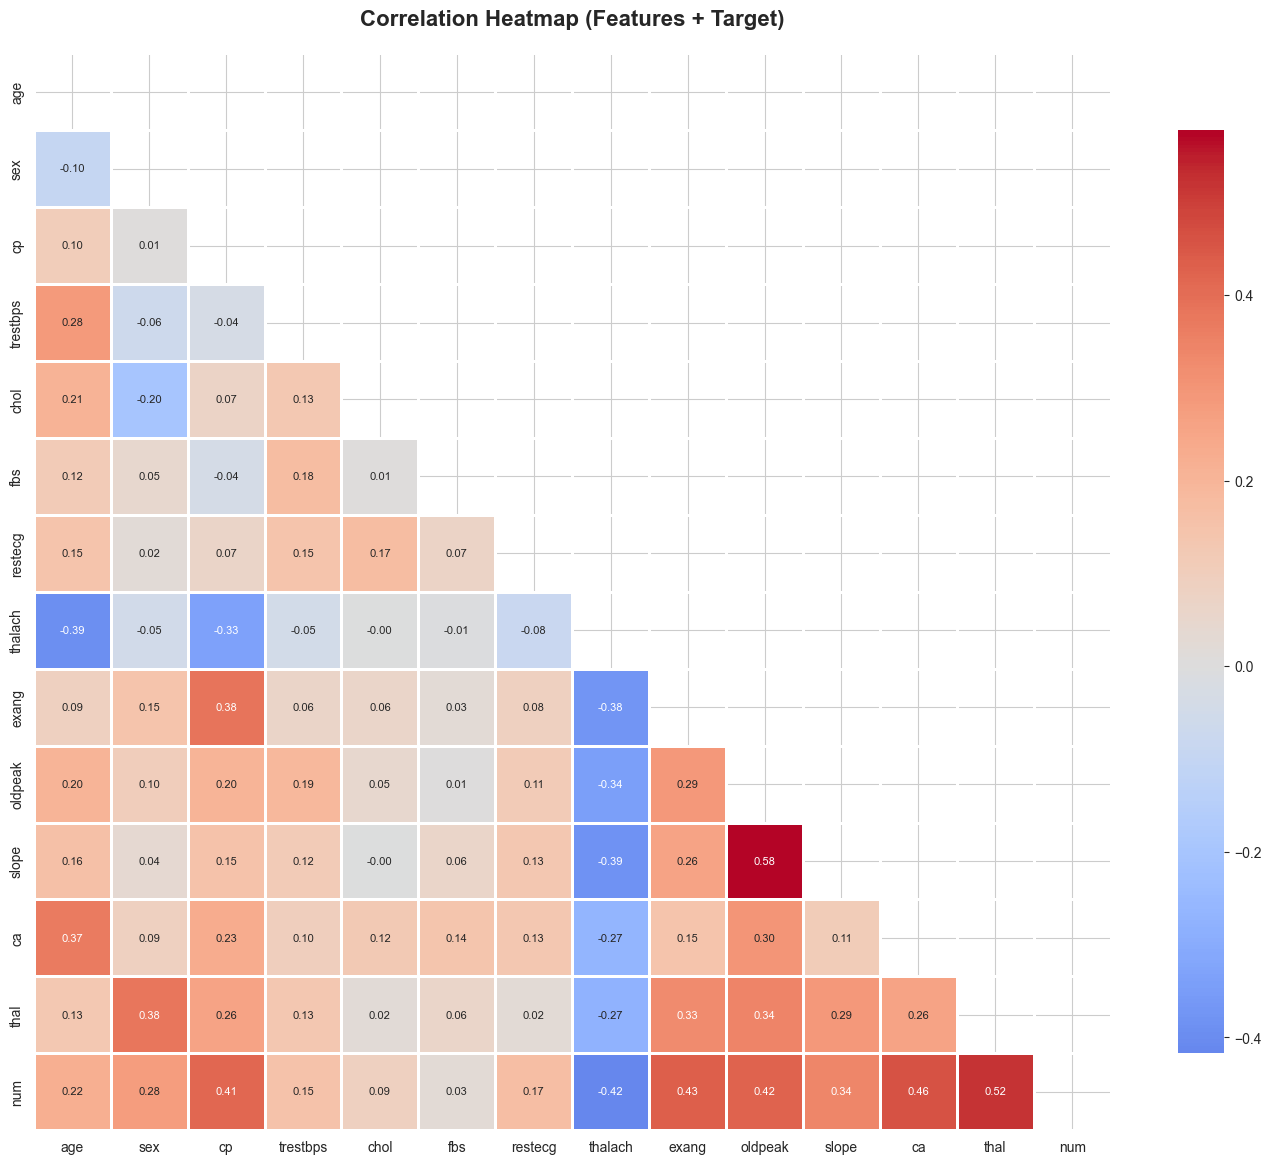


Top 10 Features Correlated with Target:
thal       0.522057
ca         0.460033
exang      0.431894
oldpeak    0.424510
thalach   -0.417167
cp         0.414446
slope      0.339213
sex        0.276816
age        0.223120
restecg    0.169202
Name: num, dtype: float64


In [38]:
# Correlation Heatmap
plt.figure(figsize=(14, 12))
correlation_matrix = pd.concat([X_clean, y_clean], axis=1).corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            annot_kws={'size': 8})
plt.title('Correlation Heatmap (Features + Target)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Display top correlations with target
target_corr = correlation_matrix.iloc[:-1, -1].sort_values(key=abs, ascending=False)
print("\nTop 10 Features Correlated with Target:")
print(target_corr.head(10))


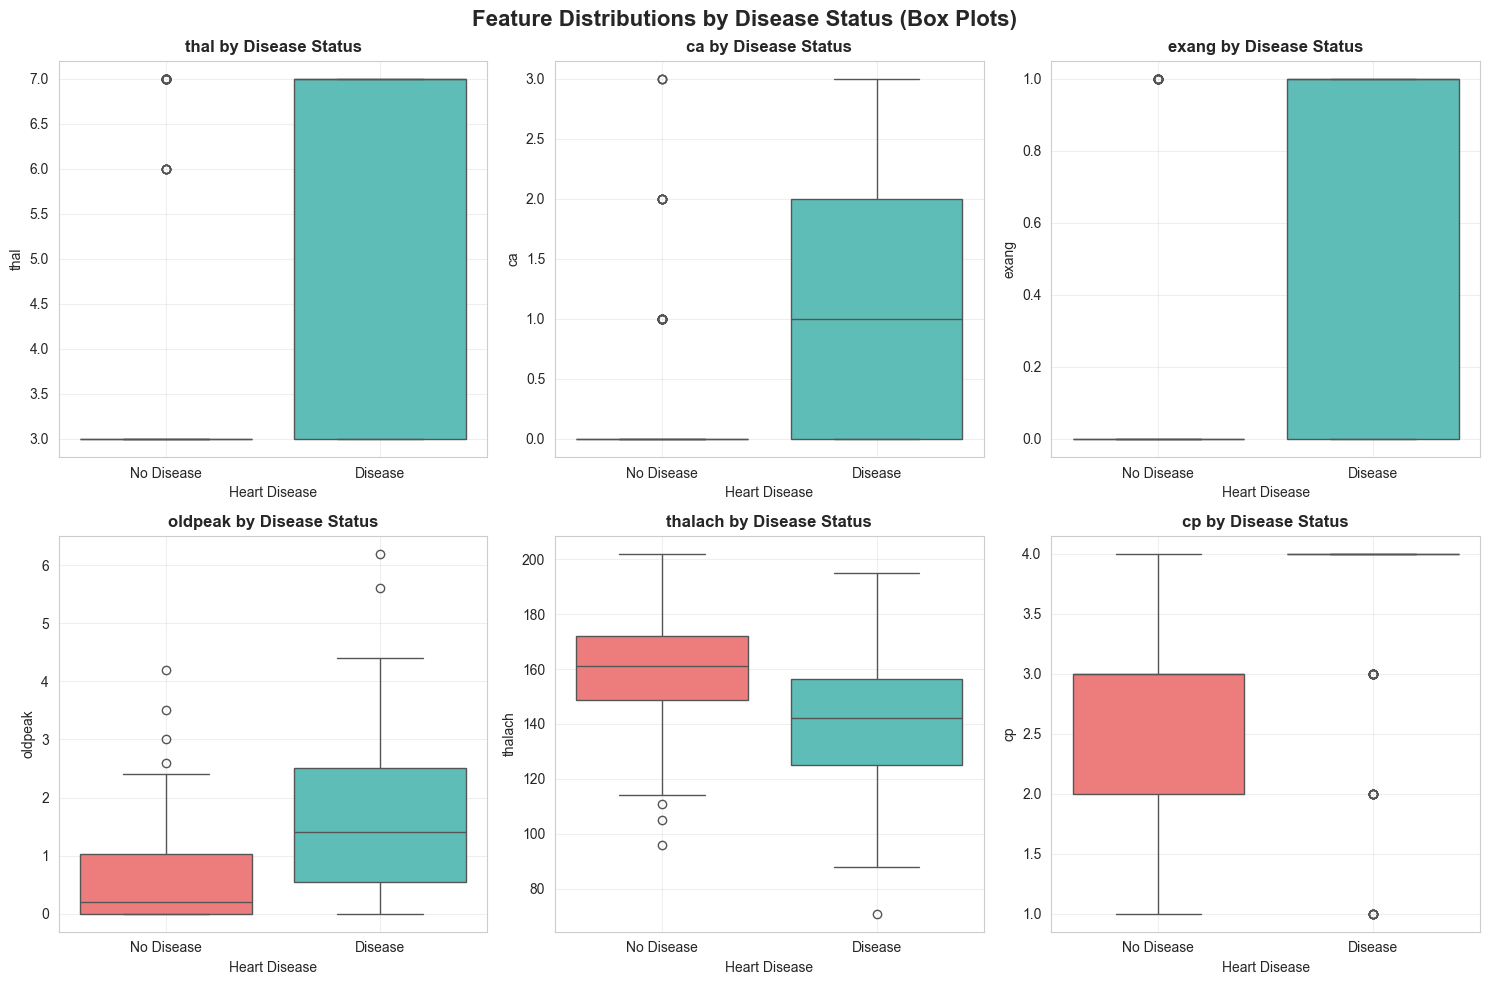

In [39]:
# Box plots for key features by target class
key_features = target_corr.head(6).index.tolist()
n_cols = 3
n_rows = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
axes = axes.flatten()

for idx, feature in enumerate(key_features):
    ax = axes[idx]
    df_plot = pd.DataFrame({feature: X_clean[feature], 'Target': y_clean})
    sns.boxplot(data=df_plot, x='Target', y=feature, ax=ax, palette=['#ff6b6b', '#4ecdc4'])
    ax.set_title(f'{feature} by Disease Status', fontsize=12, fontweight='bold')
    ax.set_xlabel('Heart Disease', fontsize=10)
    ax.set_xticklabels(['No Disease', 'Disease'])
    ax.grid(True, alpha=0.3)

plt.suptitle('Feature Distributions by Disease Status (Box Plots)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('feature_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()


In [40]:
# Summary statistics by target class
print("Summary Statistics by Disease Status:")
print("\n" + "="*80)
for target_val in [0, 1]:
    label = "No Disease" if target_val == 0 else "Disease"
    print(f"\n{label} (Target = {target_val}):")
    print(X_clean[y_clean == target_val].describe())


Summary Statistics by Disease Status:


No Disease (Target = 0):
              age         sex          cp    trestbps        chol         fbs  \
count  164.000000  164.000000  164.000000  164.000000  164.000000  164.000000   
mean    52.585366    0.560976    2.792683  129.250000  242.640244    0.140244   
std      9.511957    0.497788    0.916620   16.204739   53.456580    0.348303   
min     29.000000    0.000000    1.000000   94.000000  126.000000    0.000000   
25%     44.750000    0.000000    2.000000  120.000000  208.750000    0.000000   
50%     52.000000    1.000000    3.000000  130.000000  234.500000    0.000000   
75%     59.000000    1.000000    3.000000  140.000000  267.250000    0.000000   
max     76.000000    1.000000    4.000000  180.000000  564.000000    1.000000   

          restecg     thalach       exang     oldpeak       slope          ca  \
count  164.000000  164.000000  164.000000  164.000000  164.000000  164.000000   
mean     0.835366  158.378049    0.140244  

##  Feature Engineering & Model Development

### Step 1: Feature Engineering & Preprocessing

In [41]:
# Split data into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTest set class distribution:")
print(y_test.value_counts())


Training set shape: (242, 13)
Test set shape: (61, 13)

Training set class distribution:
num
0    131
1    111
Name: count, dtype: int64

Test set class distribution:
num
0    33
1    28
Name: count, dtype: int64


In [42]:
# Feature Scaling using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for better handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Features scaled using StandardScaler")
print(f"\nTraining set statistics after scaling:")
print(X_train_scaled.describe().round(3))


Features scaled using StandardScaler

Training set statistics after scaling:
           age      sex       cp  trestbps     chol      fbs  restecg  \
count  242.000  242.000  242.000   242.000  242.000  242.000  242.000   
mean    -0.000    0.000    0.000    -0.000    0.000   -0.000    0.000   
std      1.002    1.002    1.002     1.002    1.002    1.002    1.002   
min     -2.846   -1.464   -2.212    -2.102   -2.348   -0.411   -0.982   
25%     -0.729   -1.464   -0.927    -0.623   -0.717   -0.411   -0.982   
50%      0.162    0.683   -0.157    -0.055   -0.101   -0.411   -0.982   
75%      0.718    0.683    0.870     0.514    0.529   -0.411    1.023   
max      2.500    0.683    0.870     3.926    5.957    2.432    1.023   

       thalach    exang  oldpeak    slope       ca     thal  
count  242.000  242.000  242.000  242.000  242.000  242.000  
mean    -0.000    0.000    0.000   -0.000    0.000    0.000  
std      1.002    1.002    1.002    1.002    1.002    1.002  
min     -3.488   

### Step 2: Model Development with MLflow Tracking


In [43]:
# Initialize MLflow
mlflow.set_experiment("heart_disease_prediction")

print("MLflow experiment initialized: heart_disease_prediction")
print(f"MLflow tracking URI: {mlflow.get_tracking_uri()}")


MLflow experiment initialized: heart_disease_prediction
MLflow tracking URI: file:///Users/dineshsingh/Documents/mlops-predict-disease-risk/mlruns


In [44]:
# Function to evaluate and log model with MLflow
def evaluate_and_log_model(model, model_name, X_train, X_test, y_train, y_test, 
                          params=None, cv_scores=None):
    """Train, evaluate, and log model with MLflow"""
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_proba)
    
    # Start MLflow run
    with mlflow.start_run(run_name=model_name):
        # Log parameters
        if params:
            mlflow.log_params(params)
        
        # Log metrics
        mlflow.log_metric("train_accuracy", train_accuracy)
        mlflow.log_metric("test_accuracy", test_accuracy)
        mlflow.log_metric("test_precision", test_precision)
        mlflow.log_metric("test_recall", test_recall)
        mlflow.log_metric("test_roc_auc", test_roc_auc)
        
        # Log cross-validation scores if provided
        if cv_scores is not None:
            mlflow.log_metric("cv_accuracy_mean", cv_scores.mean())
            mlflow.log_metric("cv_accuracy_std", cv_scores.std())
        
        # Log model
        mlflow.sklearn.log_model(model, "model")
        
        # Log confusion matrix as artifact
        cm = confusion_matrix(y_test, y_test_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['No Disease', 'Disease'],
                    yticklabels=['No Disease', 'Disease'])
        plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{model_name.lower().replace(" ", "_")}.png', dpi=300)
        mlflow.log_artifact(f'confusion_matrix_{model_name.lower().replace(" ", "_")}.png')
        plt.close()
        
        # Log ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_test_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC = {test_roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title(f'ROC Curve - {model_name}', fontsize=14, fontweight='bold')
        plt.legend(loc='lower right', fontsize=11)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'roc_curve_{model_name.lower().replace(" ", "_")}.png', dpi=300)
        mlflow.log_artifact(f'roc_curve_{model_name.lower().replace(" ", "_")}.png')
        plt.close()
    
    return {
        'model': model,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_roc_auc': test_roc_auc,
        'cv_scores': cv_scores
    }

print("Evaluation function defined successfully!")


Evaluation function defined successfully!


In [45]:
# Logistic Regression with Cross-Validation
print("Training Logistic Regression Model...")
print("="*80)

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lr_model = LogisticRegression(random_state=42, max_iter=1000)
cv_scores_lr = cross_val_score(lr_model, X_train_scaled, y_train, 
                               cv=cv, scoring='accuracy', n_jobs=-1)

print(f"Cross-Validation Accuracy: {cv_scores_lr.mean():.4f} (+/- {cv_scores_lr.std()*2:.4f})")
print(f"Individual CV scores: {cv_scores_lr}")

# Train and evaluate with MLflow
lr_params = {
    'model_type': 'Logistic Regression',
    'max_iter': 1000,
    'random_state': 42,
    'scaler': 'StandardScaler'
}

lr_results = evaluate_and_log_model(
    lr_model, 
    "Logistic Regression",
    X_train_scaled, 
    X_test_scaled, 
    y_train, 
    y_test,
    params=lr_params,
    cv_scores=cv_scores_lr
)

print("\nLogistic Regression Results:")
print(f"Train Accuracy: {lr_results['train_accuracy']:.4f}")
print(f"Test Accuracy: {lr_results['test_accuracy']:.4f}")
print(f"Test Precision: {lr_results['test_precision']:.4f}")
print(f"Test Recall: {lr_results['test_recall']:.4f}")
print(f"Test ROC-AUC: {lr_results['test_roc_auc']:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, lr_model.predict(X_test_scaled), 
                          target_names=['No Disease', 'Disease']))


Training Logistic Regression Model...


/Users/dineshsingh/Documents/mlops-predict-disease-risk/mlops/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/dineshsingh/Documents/mlops-predict-disease-risk/mlops/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/dineshsingh/Documents/mlops-predict-disease-risk/mlops/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/dineshsingh/Documents/mlops-predict-disease-risk/mlops/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/dineshsingh/Documents/mlops-predict-disease-risk/mlops/lib/p

Cross-Validation Accuracy: 0.8264 (+/- 0.0344)
Individual CV scores: [0.85714286 0.81632653 0.8125     0.8125     0.83333333]


2025/12/28 09:11:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Logistic Regression Results:
Train Accuracy: 0.8512
Test Accuracy: 0.8689
Test Precision: 0.8125
Test Recall: 0.9286
Test ROC-AUC: 0.9513

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.93      0.82      0.87        33
     Disease       0.81      0.93      0.87        28

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61



### Model 2: Random Forest Classifier


In [46]:
# Random Forest with Cross-Validation
print("Training Random Forest Classifier...")
print("="*80)

# Cross-validation
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
cv_scores_rf = cross_val_score(rf_model, X_train_scaled, y_train, 
                               cv=cv, scoring='accuracy', n_jobs=-1)

print(f"Cross-Validation Accuracy: {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std()*2:.4f})")
print(f"Individual CV scores: {cv_scores_rf}")

# Train and evaluate with MLflow
rf_params = {
    'model_type': 'Random Forest',
    'n_estimators': 100,
    'random_state': 42,
    'scaler': 'StandardScaler'
}

rf_results = evaluate_and_log_model(
    rf_model,
    "Random Forest",
    X_train_scaled,
    X_test_scaled,
    y_train,
    y_test,
    params=rf_params,
    cv_scores=cv_scores_rf
)

print("\nRandom Forest Results:")
print(f"Train Accuracy: {rf_results['train_accuracy']:.4f}")
print(f"Test Accuracy: {rf_results['test_accuracy']:.4f}")
print(f"Test Precision: {rf_results['test_precision']:.4f}")
print(f"Test Recall: {rf_results['test_recall']:.4f}")
print(f"Test ROC-AUC: {rf_results['test_roc_auc']:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, rf_model.predict(X_test_scaled), 
                          target_names=['No Disease', 'Disease']))


Training Random Forest Classifier...


2025/12/28 09:11:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Cross-Validation Accuracy: 0.8016 (+/- 0.0339)
Individual CV scores: [0.79591837 0.81632653 0.8125     0.8125     0.77083333]


2025/12/28 09:11:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Random Forest Results:
Train Accuracy: 1.0000
Test Accuracy: 0.8852
Test Precision: 0.8182
Test Recall: 0.9643
Test ROC-AUC: 0.9513

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.96      0.82      0.89        33
     Disease       0.82      0.96      0.89        28

    accuracy                           0.89        61
   macro avg       0.89      0.89      0.89        61
weighted avg       0.90      0.89      0.89        61



### Model Comparison and Feature Importance


Model Comparison:
                 Model  CV Accuracy (Mean)  CV Accuracy (Std)  Test Accuracy  \
0  Logistic Regression              0.8264             0.0172         0.8689   
1        Random Forest              0.8016             0.0169         0.8852   

   Test Precision  Test Recall  Test ROC-AUC  
0          0.8125       0.9286        0.9513  
1          0.8182       0.9643        0.9513  



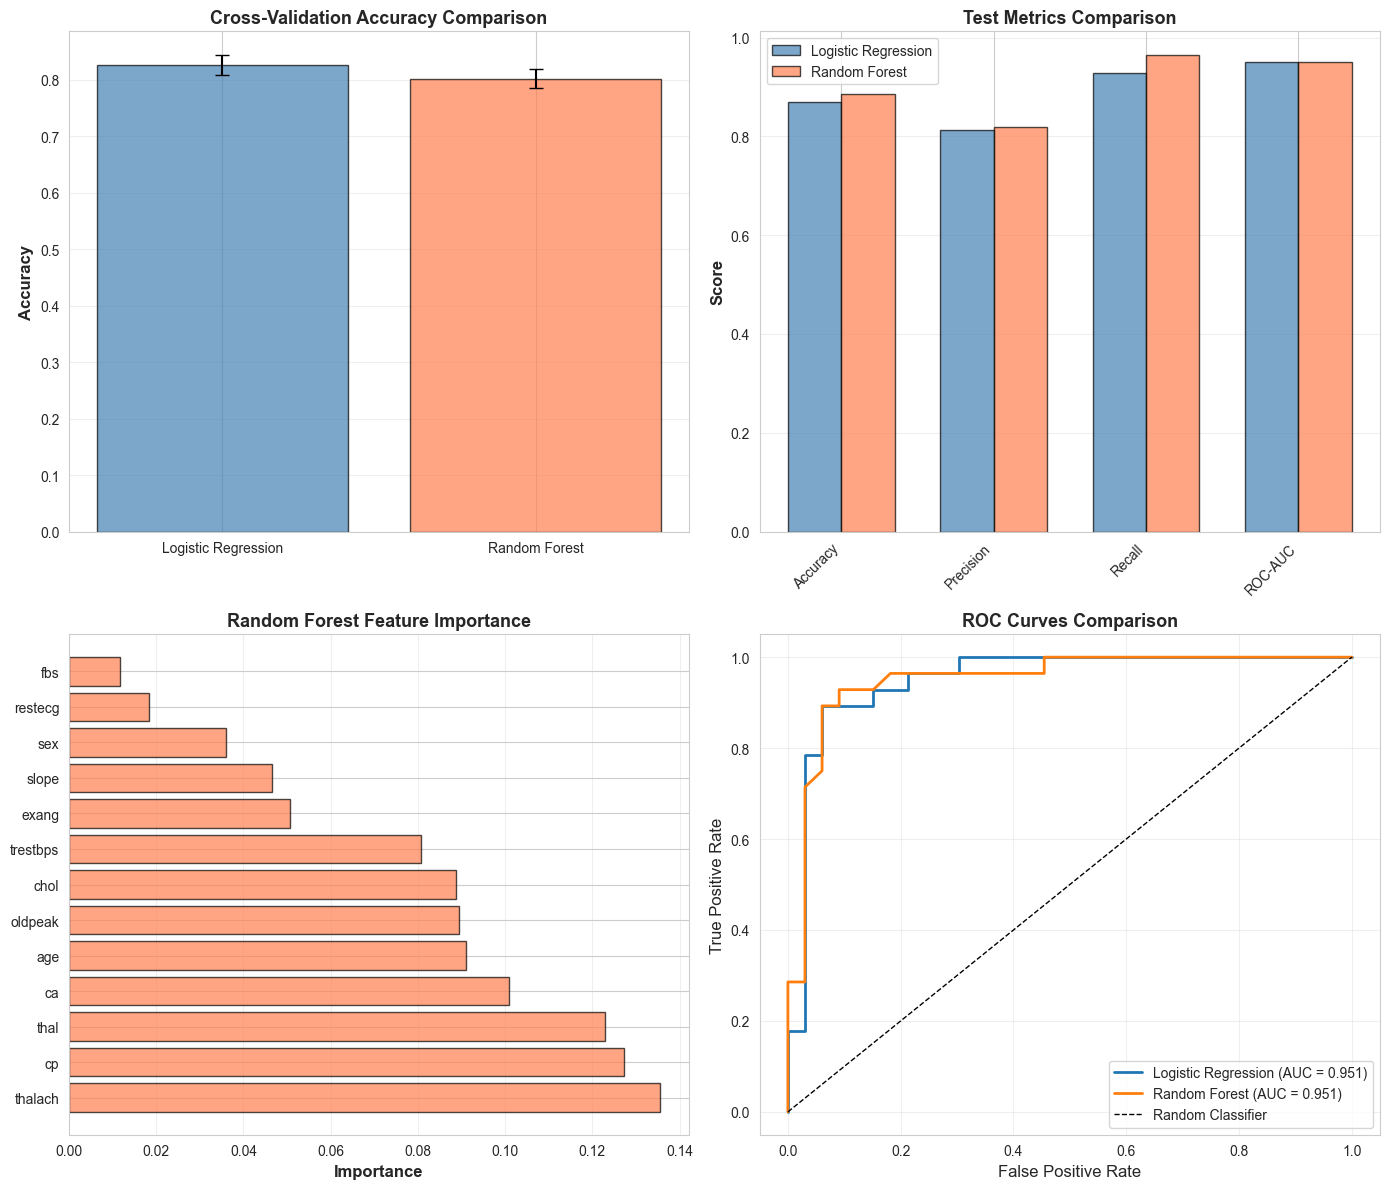

In [47]:
# Model Comparison
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'CV Accuracy (Mean)': [lr_results['cv_scores'].mean(), rf_results['cv_scores'].mean()],
    'CV Accuracy (Std)': [lr_results['cv_scores'].std(), rf_results['cv_scores'].std()],
    'Test Accuracy': [lr_results['test_accuracy'], rf_results['test_accuracy']],
    'Test Precision': [lr_results['test_precision'], rf_results['test_precision']],
    'Test Recall': [lr_results['test_recall'], rf_results['test_recall']],
    'Test ROC-AUC': [lr_results['test_roc_auc'], rf_results['test_roc_auc']]
})

print("Model Comparison:")
print("="*80)
print(comparison_df.round(4))
print("\n" + "="*80)

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# CV Accuracy comparison
axes[0, 0].bar(['Logistic Regression', 'Random Forest'], 
               [lr_results['cv_scores'].mean(), rf_results['cv_scores'].mean()],
               yerr=[lr_results['cv_scores'].std(), rf_results['cv_scores'].std()],
               color=['steelblue', 'coral'], alpha=0.7, capsize=5, edgecolor='black')
axes[0, 0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Cross-Validation Accuracy Comparison', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Test metrics comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'ROC-AUC']
lr_metrics = [lr_results['test_accuracy'], lr_results['test_precision'], 
              lr_results['test_recall'], lr_results['test_roc_auc']]
rf_metrics = [rf_results['test_accuracy'], rf_results['test_precision'], 
              rf_results['test_recall'], rf_results['test_roc_auc']]

x = np.arange(len(metrics))
width = 0.35
axes[0, 1].bar(x - width/2, lr_metrics, width, label='Logistic Regression', 
               color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 1].bar(x + width/2, rf_metrics, width, label='Random Forest', 
               color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Test Metrics Comparison', fontsize=13, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(metrics, rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Feature importance for Random Forest
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

axes[1, 0].barh(feature_importance['feature'], feature_importance['importance'], 
                color='coral', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Importance', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Random Forest Feature Importance', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# ROC Curves comparison
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_model.predict_proba(X_test_scaled)[:, 1])
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_model.predict_proba(X_test_scaled)[:, 1])

axes[1, 1].plot(fpr_lr, tpr_lr, linewidth=2, label=f"Logistic Regression (AUC = {lr_results['test_roc_auc']:.3f})")
axes[1, 1].plot(fpr_rf, tpr_rf, linewidth=2, label=f"Random Forest (AUC = {rf_results['test_roc_auc']:.3f})")
axes[1, 1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[1, 1].set_xlabel('False Positive Rate', fontsize=12)
axes[1, 1].set_ylabel('True Positive Rate', fontsize=12)
axes[1, 1].set_title('ROC Curves Comparison', fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Log comparison plot to MLflow
with mlflow.start_run(run_name="Model Comparison"):
    mlflow.log_artifact('model_comparison.png')
    mlflow.log_metric("best_model_accuracy", max(lr_results['test_accuracy'], rf_results['test_accuracy']))
    mlflow.log_metric("best_model_roc_auc", max(lr_results['test_roc_auc'], rf_results['test_roc_auc']))


In [48]:
# Determine best model
best_model_name = 'Random Forest' if rf_results['test_roc_auc'] > lr_results['test_roc_auc'] else 'Logistic Regression'
best_model = rf_model if rf_results['test_roc_auc'] > lr_results['test_roc_auc'] else lr_model

print("="*80)
print(f"BEST MODEL: {best_model_name}")
print("="*80)
print(f"Selected based on highest ROC-AUC score")
print(f"\nBest Model Metrics:")
if best_model_name == 'Random Forest':
    print(f"  Test Accuracy: {rf_results['test_accuracy']:.4f}")
    print(f"  Test Precision: {rf_results['test_precision']:.4f}")
    print(f"  Test Recall: {rf_results['test_recall']:.4f}")
    print(f"  Test ROC-AUC: {rf_results['test_roc_auc']:.4f}")
else:
    print(f"  Test Accuracy: {lr_results['test_accuracy']:.4f}")
    print(f"  Test Precision: {lr_results['test_precision']:.4f}")
    print(f"  Test Recall: {lr_results['test_recall']:.4f}")
    print(f"  Test ROC-AUC: {lr_results['test_roc_auc']:.4f}")

# Save the best model and scaler for later use
import pickle

model_data = {
    'model': best_model,
    'scaler': scaler,
    'feature_names': X_train.columns.tolist(),
    'model_name': best_model_name
}

with open('best_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("\nBest model and scaler saved to 'best_model.pkl'")


BEST MODEL: Logistic Regression
Selected based on highest ROC-AUC score

Best Model Metrics:
  Test Accuracy: 0.8689
  Test Precision: 0.8125
  Test Recall: 0.9286
  Test ROC-AUC: 0.9513

Best model and scaler saved to 'best_model.pkl'
